# Dimensionality Reductions for the various datasets and EL2N vizualizations

## Libraries & Constants

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.models as models

LIGHT_COLORS = [
    "#e41a1c",  # Red
    "#377eb8",  # Blue
    "#4daf4a",  # Green
    "#984ea3",  # Purple
    "#ff7f00",  # Orange
    "#ffff33",  # Yellow
    "#a65628",  # Brown
    "#f781bf",  # Pink
    "#999999",  # Gray
    "#66c2a5"   # Turquoise
]

DARK_COLORS = [
    "#b10026",  # Dark red
    "#08519c",  # Dark blue
    "#006d2c",  # Dark green
    "#54278f",  # Dark purple
    "#e6550d",  # Dark orange
    "#d9f0a3",  # Light yellow-green
    "#8c2d04",  # Dark brown
    "#e7298a",  # Magenta
    "#525252",  # Dark gray
    "#238b45"   # Deep turquoise
]

## Resnet architecutre for CIFAR-10 features

In [2]:
class CIFAR10Classifier(nn.Module):
    """ResNet18 model for CIFAR-10 classification."""
    def __init__(self):
        super(CIFAR10Classifier, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.model.maxpool = nn.Identity()
        self.model.fc = nn.Linear(self.model.fc.in_features, 10)

    def forward(self, x):
        return self.model(x)

    def extract_features(self, x):
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        x = self.model.layer4(x)
        x = self.model.avgpool(x)
        x = torch.flatten(x, 1)
        return x

## Data Loading

In [3]:
def load_dataset(dataset_name):
    """Load the dataset and EL2N scores."""
    transform = transforms.Compose([
        transforms.ToTensor(),
    ])
    
    if dataset_name == 'mnist':
        dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
        csv_path = "data/el2n_scores_digits_sorted.csv"
        n_subset = 60000
        perplexity = 50
        features_dim = 28*28
        title_prefix = "MNIST"
        feature_extractor = None
    elif dataset_name == 'fashion':
        dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)
        csv_path = "data/el2n_scores_fashion_sorted.csv"
        n_subset = 60000
        perplexity = 75
        features_dim = 28*28
        title_prefix = "Fashion-MNIST"
        feature_extractor = None
    elif dataset_name == 'cifar10':
        dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
        csv_path = "data/el2n_scores_cifar10_sorted.csv"
        n_subset = 50000
        perplexity = 40
        features_dim = 512
        title_prefix = "CIFAR-10"
        
        # Load the CIFAR-10 classifier model
        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        feature_extractor = CIFAR10Classifier().to(device)
        feature_extractor.load_state_dict(torch.load("cifar10_resnet18.pth", map_location=device))
        feature_extractor.eval()
    else:
        raise ValueError(f"Unknown dataset: {dataset_name}")
    
    # Load EL2N scores
    el2n_df = pd.read_csv(csv_path)
    el2n_scores = el2n_df.set_index('index')['el2n_score']
    
    return dataset, el2n_scores, n_subset, perplexity, features_dim, title_prefix, feature_extractor

## Extract Features and EL2N scores

In [ ]:
def extract_features_and_scores(dataset, el2n_scores, n_subset, features_dim, feature_extractor=None):
    """Extract features and EL2N scores for the dataset."""
    subset_indices = np.random.choice(len(dataset), n_subset, replace=False)
    subset_indices.sort()
    
    X = np.zeros((n_subset, features_dim))
    labels = np.zeros(n_subset, dtype=int)
    score_array = np.zeros(n_subset)
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    for i, idx in enumerate(subset_indices):
        img, label = dataset[idx]
        
        if feature_extractor is not None:
            img_tensor = img.unsqueeze(0).to(device)
            with torch.no_grad():
                feat = feature_extractor.extract_features(img_tensor)
            X[i] = feat.cpu().numpy().reshape(-1)
        else:
            # Use raw pixel values (for MNIST and Fashion-MNIST)
            X[i] = img.numpy().reshape(-1)
            
        labels[i] = label
        score_array[i] = el2n_scores.get(idx, np.nan)
    
    return X, labels, score_array

## Running t-SNE

In [5]:
def run_tsne(X, perplexity=30, random_state=42, n_iter=1000):
    """Run t-SNE dimensionality reduction."""
    print("Running t-SNE, please wait...")
    tsne = TSNE(
        n_components=2, 
        random_state=random_state, 
        perplexity=perplexity, 
        n_iter=n_iter, 
        init='random'
    )
    X_embedded = tsne.fit_transform(X)
    return X_embedded

In [6]:
def plot_tsne(X_embedded, labels, score_array, n_subset, title_prefix, k=10000, show_hardest=True):
    """Plot t-SNE visualization highlighting hardest or easiest examples."""
    if show_hardest:
        # Find top k examples by highest EL2N score (hardest)
        selected_indices = np.argsort(-score_array)[:k]
        title_suffix = f"Highest EL2N Highlighted"
    else:
        # Find top k examples by lowest EL2N score (easiest)
        selected_indices = np.argsort(score_array)[:k]
        title_suffix = f"Easiest EL2N Highlighted"
    
    fig, ax = plt.subplots(figsize=(12, 10))
    
    for cls in range(10):
        idx = labels == cls
        ax.scatter(
            X_embedded[idx, 0],
            X_embedded[idx, 1],
            color=LIGHT_COLORS[cls],
            label=f"Class {cls}",
            s=10,
            alpha=0.5,
            edgecolors='none'
        )
    
    for cls in range(10):
        idx = (labels == cls) & (np.isin(np.arange(len(labels)), selected_indices))
        ax.scatter(
            X_embedded[idx, 0],
            X_embedded[idx, 1],
            color=DARK_COLORS[cls],
            s=20,
            alpha=1.0,
            edgecolors='k',
            linewidth=0.3
        )
    
    for cls in range(10):
        idx = labels == cls
        if np.sum(idx) == 0:
            continue
        median_x = np.median(X_embedded[idx, 0])
        median_y = np.median(X_embedded[idx, 1])
        ax.text(
            median_x,
            median_y,
            str(cls),
            fontsize=16,
            fontweight='bold',
            color=DARK_COLORS[cls],
            ha='center',
            va='center'
        )
    
    ax.set_title(f"{title_prefix} t-SNE on {n_subset} samples with Top {k} {title_suffix}", fontsize=16)
    ax.axis('off')
    ax.legend(markerscale=2, loc='upper right', fontsize=10)
    plt.tight_layout()
    plt.show()

## All together

In [7]:
def visualize_dataset(dataset_name, k=10000):
    """Main function to visualize a dataset with t-SNE."""
    dataset, el2n_scores, n_subset, perplexity, features_dim, title_prefix, feature_extractor = load_dataset(dataset_name)
    
    X, labels, score_array = extract_features_and_scores(
        dataset, el2n_scores, n_subset, features_dim, feature_extractor
    )
    
    if title_prefix == "CIFAR-10":
        n_iter = 2000
    else:
        n_iter = 1000
    
    X_embedded = run_tsne(X, perplexity=perplexity, n_iter=n_iter, random_state=42)

    plot_tsne(X_embedded, labels, score_array, n_subset, title_prefix, k, show_hardest=True)
    
    plot_tsne(X_embedded, labels, score_array, n_subset, title_prefix, k, show_hardest=False)

Running t-SNE, please wait...


c:\Users\Christian\uni\GANs-Data-Diet\.venv\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


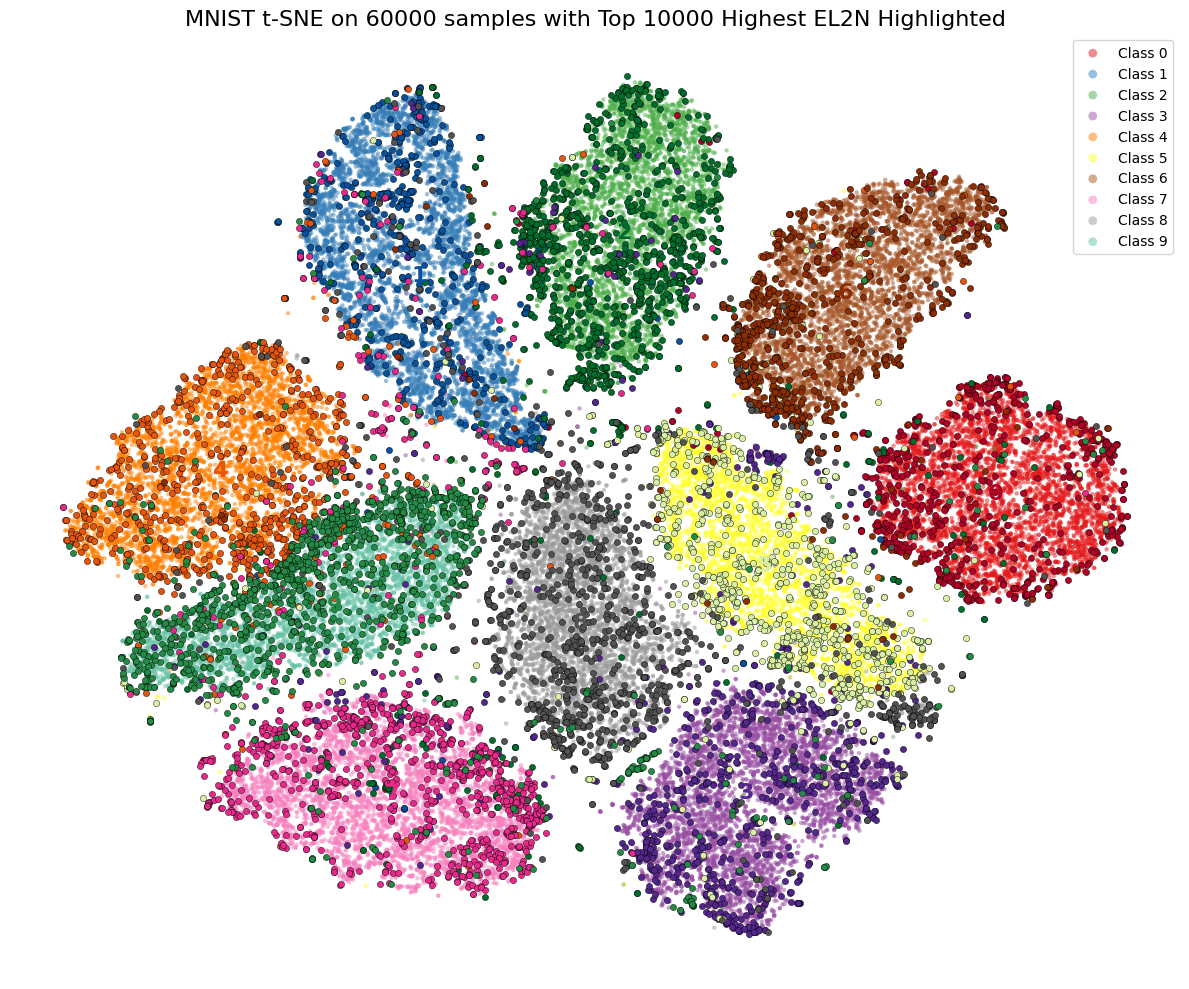

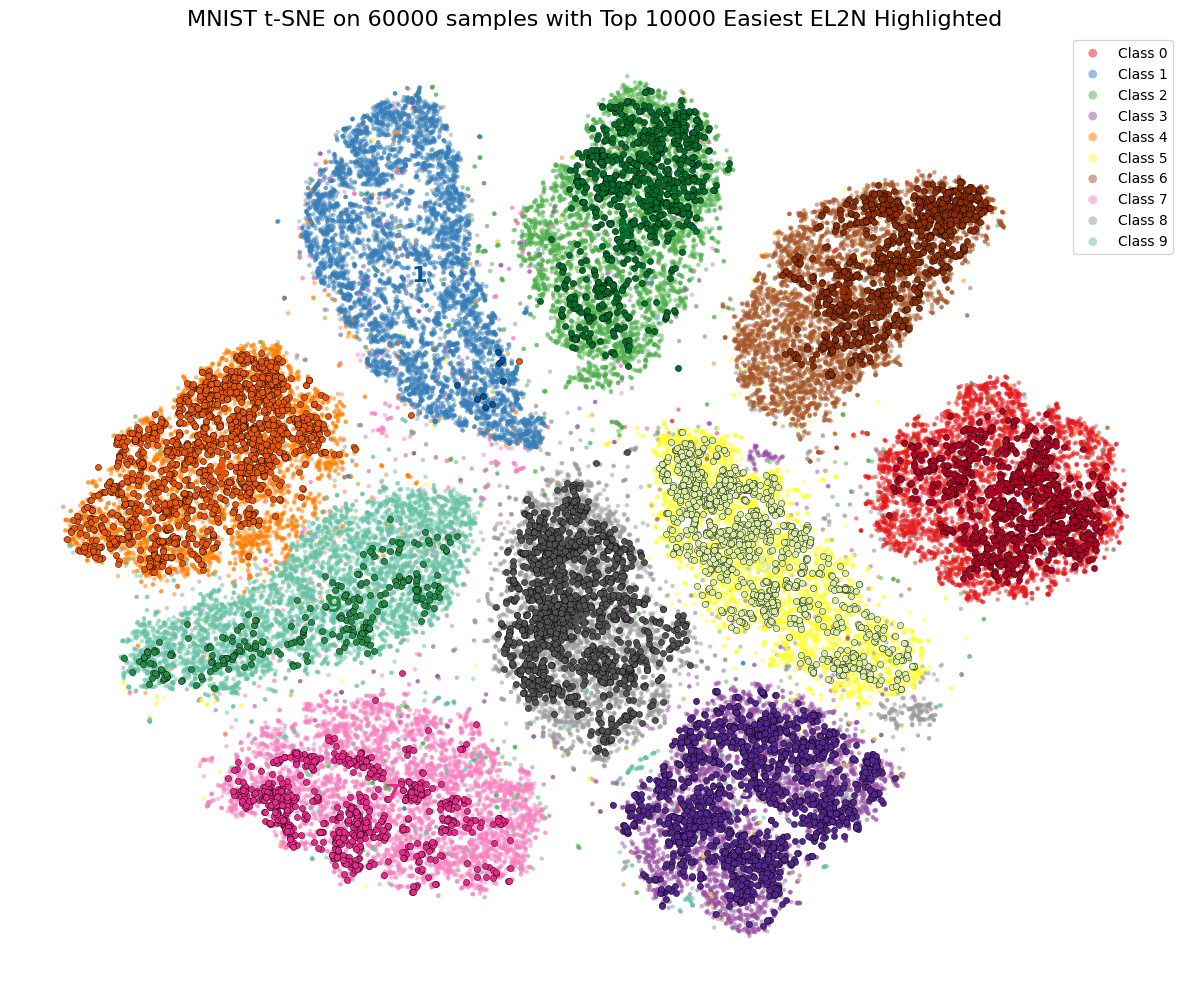

In [8]:
visualize_dataset('mnist', k=10000)

Running t-SNE, please wait...


c:\Users\Christian\uni\GANs-Data-Diet\.venv\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


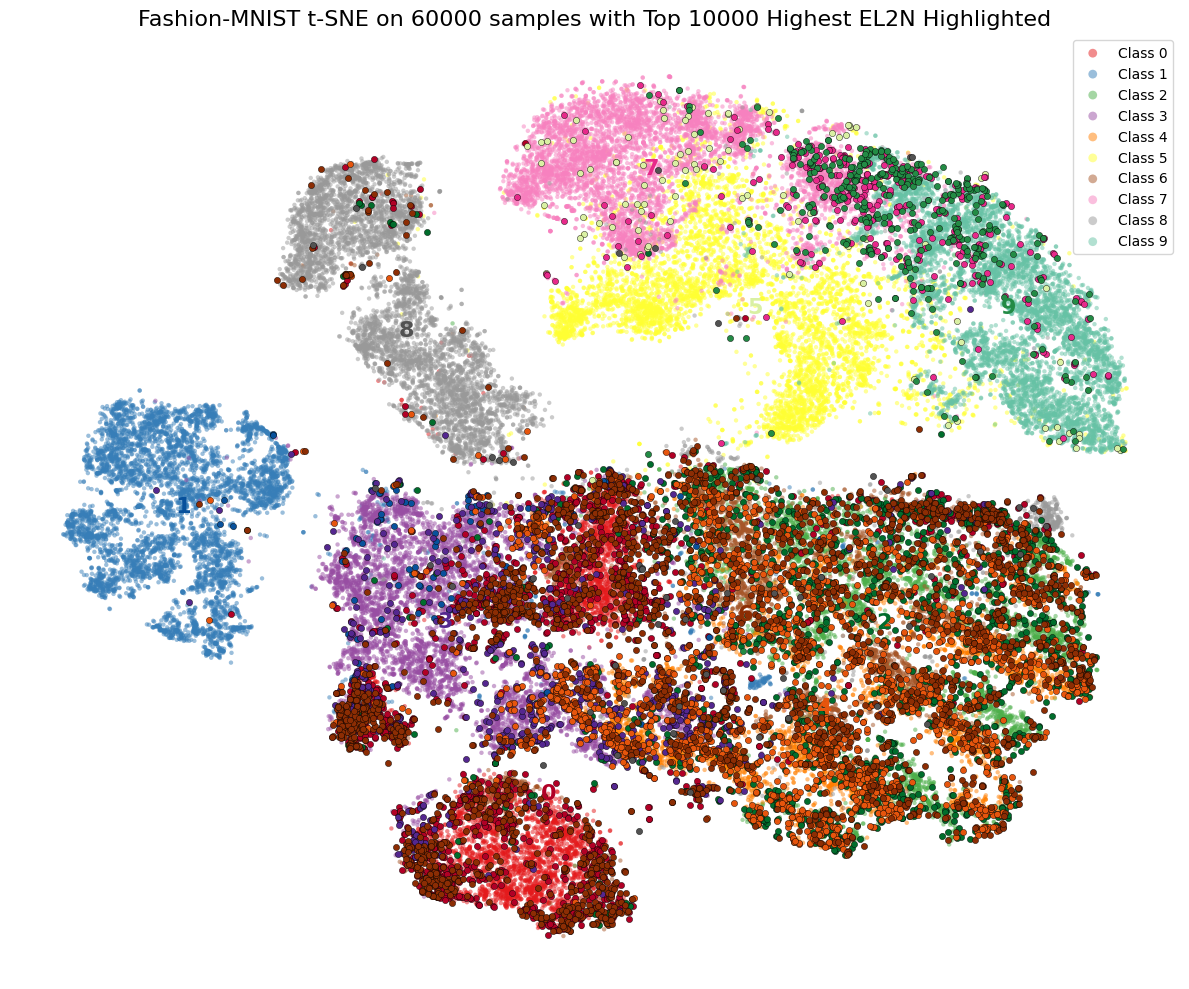

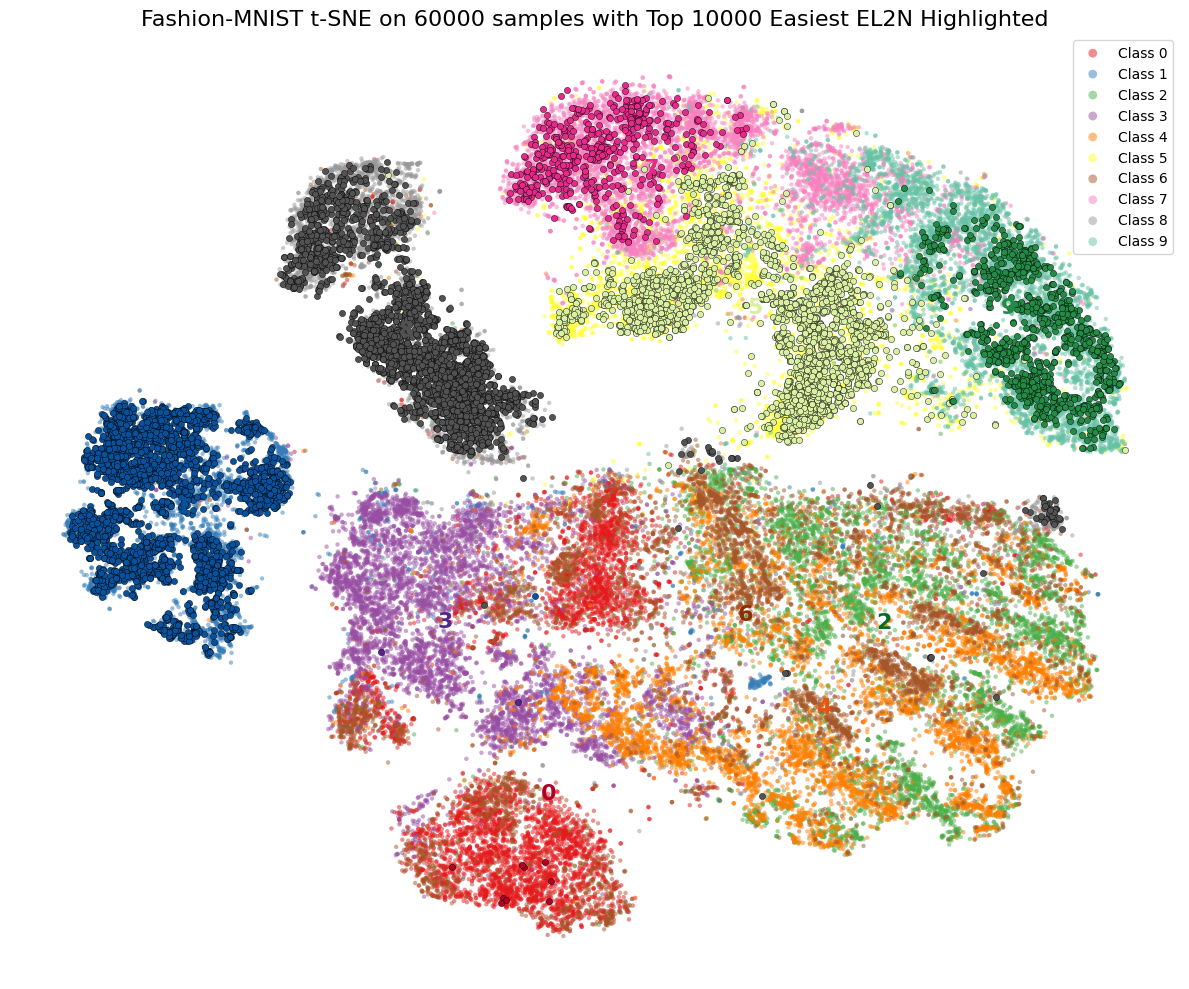

In [9]:
visualize_dataset('fashion', k=10000)

Files already downloaded and verified


c:\Users\Christian\uni\GANs-Data-Diet\.venv\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Christian\uni\GANs-Data-Diet\.venv\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\Christian\AppData\Local\Temp\ipykernel_27032\1149184644.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://

Running t-SNE, please wait...


c:\Users\Christian\uni\GANs-Data-Diet\.venv\lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


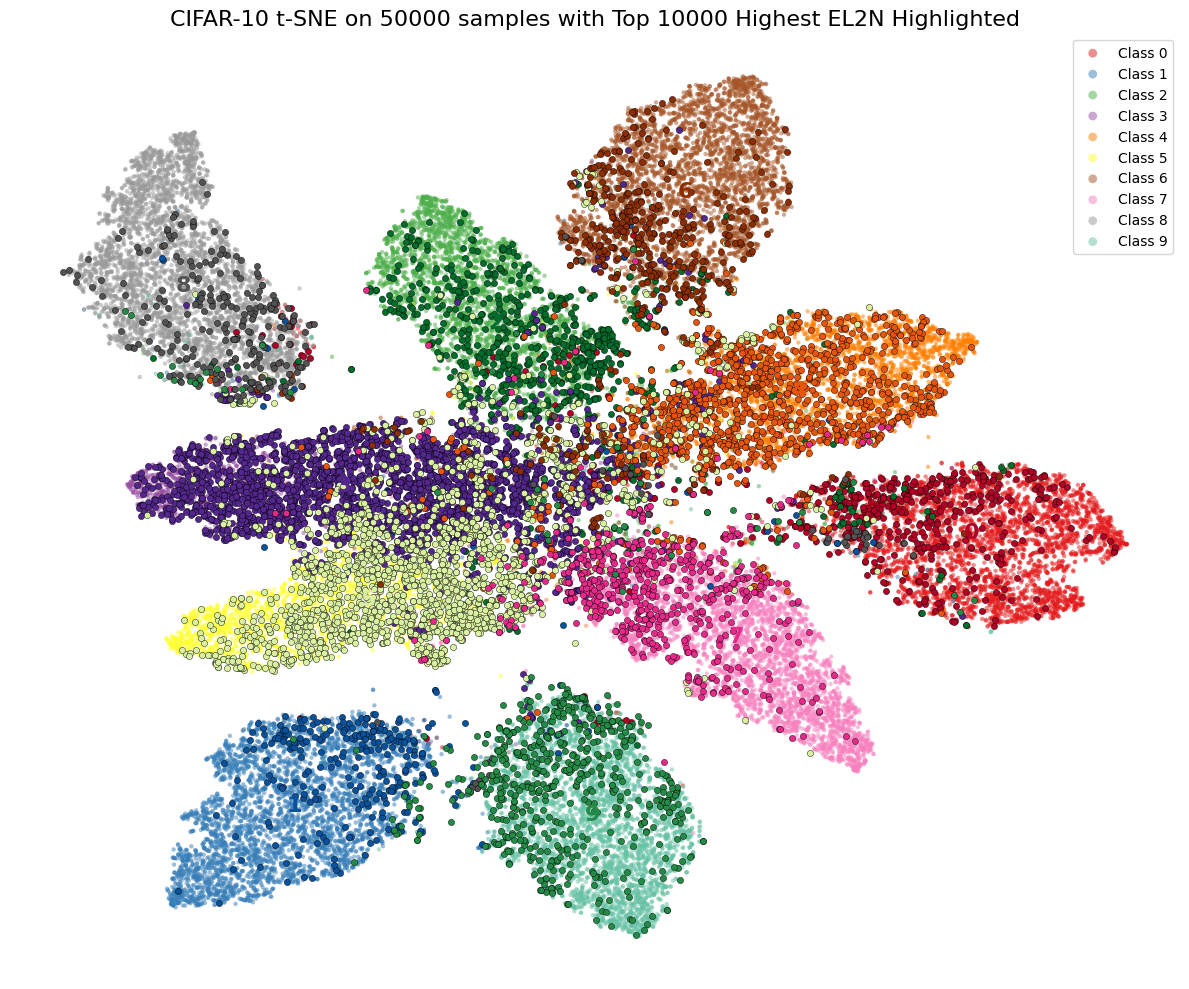

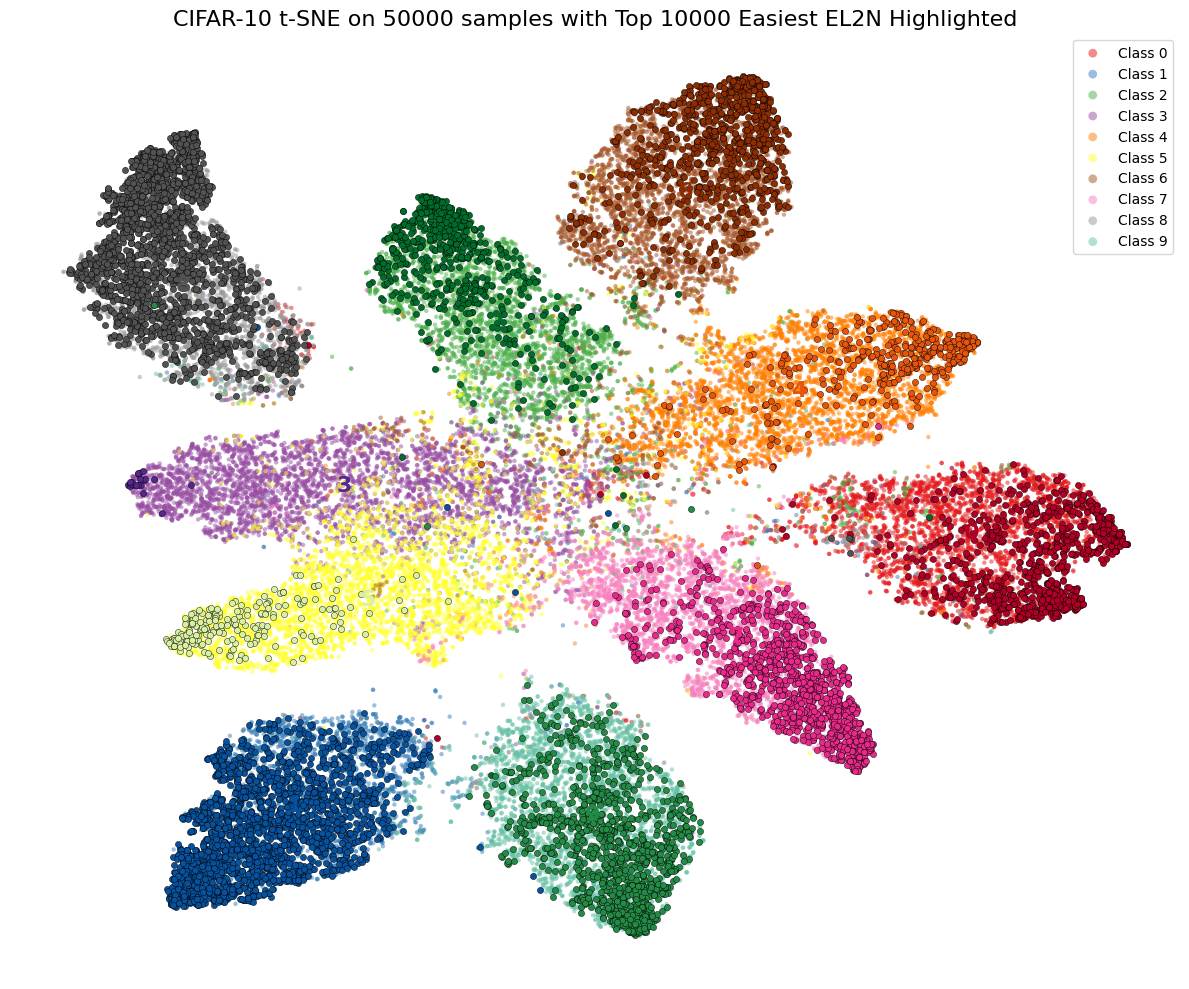

In [10]:
visualize_dataset('cifar10', k=10000)

# CIFAR-10 training

In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torchvision.models as models

class CIFAR10Classifier(nn.Module):
    def __init__(self):
        super(CIFAR10Classifier, self).__init__()
        self.model = models.resnet18(pretrained=True)
        self.model.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1, bias=False)
        self.model.maxpool = nn.Identity()
        self.model.fc = nn.Linear(self.model.fc.in_features, 10)

    def forward(self, x):
        return self.model(x)

    def extract_features(self, x):
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        x = self.model.layer4(x)
        x = self.model.avgpool(x)
        x = torch.flatten(x, 1)
        return x

# # Hyperparameters
# batch_size = 128
# epochs = 10
# lr = 0.001
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# # Data transforms and loaders
# transform = transforms.Compose([
#     transforms.ToTensor(),
#     transforms.Normalize((0.5,), (0.5,))
# ])

# train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
# train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

# # Model, loss, optimizer
# model = CIFAR10Classifier().to(device)
# criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=lr)

# # Training loop
# model.train()
# for epoch in range(epochs):
#     running_loss = 0.0
#     correct, total = 0, 0
#     for images, labels in train_loader:
#         images, labels = images.to(device), labels.to(device)

#         optimizer.zero_grad()
#         outputs = model(images)
#         loss = criterion(outputs, labels)
#         loss.backward()
#         optimizer.step()

#         running_loss += loss.item() * images.size(0)
#         _, predicted = outputs.max(1)
#         total += labels.size(0)
#         correct += predicted.eq(labels).sum().item()

#     print(f"Epoch [{epoch+1}/{epochs}] Loss: {running_loss/total:.4f} Accuracy: {100.0 * correct / total:.2f}%")

# # Save the trained model
# torch.save(model.state_dict(), "cifar10_resnet18.pth")
